# Chest X-ray Classification and Localization using DenseNet

This notebook implements a transfer learning approach using DenseNet for chest X-ray classification and localization on the NIH Chest X-ray dataset.

In [1]:
!pip install torch torchvision pandas numpy matplotlib tqdm scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.9/101.9 kB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 23.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 43.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 254.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 223.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 169.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 28.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 68.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 

In [6]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
from torchvision import models
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

## Data Curation

In [152]:
# Define paths
BASE_PATH = 'DL_for_HIN_Chest_X_Ray'
IMAGES_PATH = os.path.join(BASE_PATH, 'archive','images', 'images')
CSV_PATH = os.path.join(BASE_PATH, 'Data_Entry_2017_filtered_2.csv')
BBOX_PATH = os.path.join(BASE_PATH,'archive', 'BBox_List_2017.csv')

# Load the filtered dataset
df = pd.read_csv(CSV_PATH)
df.rename(columns={'Finding Labels': 'Finding Label'}, inplace=True)
df.drop(columns=['Follow-up #', 'Patient ID', 'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width','Height]', 'OriginalImagePixelSpacing[x', 'y]'], inplace=True)
no_finding_images = df[df['Finding Label'] == 'No Finding'].head(2016)


bbox_df = pd.read_csv(BBOX_PATH)
bbox_df.drop(columns=['Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8'], inplace=True)
bbox_df.columns = ['Image Index','Finding Label', 'x', 'y', 'width', 'height']

combined_df = pd.concat([no_finding_images, bbox_df])

combined_df.shape
combined_df['Image Index'].value_counts()

combined_df[combined_df['Image Index'] == '00010277_000.png']

,Image Index,Finding Label,x,y,width,height
326,00010277_000.png,Effusion,863.004444,693.229045,72.817778,112.640000
474,00010277_000.png,Infiltrate,633.173333,416.749045,271.928889,221.866667
590,00010277_000.png,Mass,297.528889,310.935712,540.444444,277.617778
752,00010277_000.png,Pneumonia,642.275556,423.575712,265.102222,223.004444


In [144]:
import os
from PIL import Image

# Define the new directory to save resized images
resized_images_dir = 'resized_images'
os.makedirs(resized_images_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Strip whitespace from image filenames
combined_df['Image Index'] = combined_df['Image Index'].str.strip()

# Iterate over all images_[XXX] folders in the archive directory
archive_path = os.path.join('DL_for_HIN_Chest_X_Ray', 'archive')  # Adjust this path as needed

# Resize and save images
for index, row in combined_df.iterrows():
    image_name = row['Image Index']
    found = False  # Flag to check if the image was found

    # Walk through the archive directory
    for root, dirs, files in os.walk(archive_path):
        if image_name in files:
            image_path = os.path.join(root, image_name)  # Construct the full image path
            print(f"Found image: {image_path}")  # Debugging line
            found = True
            try:
                # Open the image
                with Image.open(image_path) as img:
                    # Resize the image
                    img_resized = img.resize((224, 224))
                    # Save the resized image to the new directory
                    img_resized.save(os.path.join(resized_images_dir, image_name))
                    print(f"Saved resized image: {image_name}")  # Debugging line
            except OSError as e:
                print(f"Error processing {image_name}: {e}")
            except Exception as e:
                print(f"Unexpected error with {image_name}: {e}")
            break  # Exit the loop once the image is found

    if not found:
        print(f"File does not exist in any subdirectory: {image_name}")
    print(index)

Found image: DL_for_HIN_Chest_X_Ray/archive/images_001/images/00000002_000.png
Saved resized image: 00000002_000.png
1
Found image: DL_for_HIN_Chest_X_Ray/archive/images_001/images/00000005_000.png
Saved resized image: 00000005_000.png
3
Found image: DL_for_HIN_Chest_X_Ray/archive/images_001/images/00000005_001.png
Saved resized image: 00000005_001.png
4
Found image: DL_for_HIN_Chest_X_Ray/archive/images_001/images/00000005_002.png
Saved resized image: 00000005_002.png
5
Found image: DL_for_HIN_Chest_X_Ray/archive/images_001/images/00000005_003.png
Saved resized image: 00000005_003.png
6
Found image: DL_for_HIN_Chest_X_Ray/archive/images_001/images/00000005_004.png
Saved resized image: 00000005_004.png
7
Found image: DL_for_HIN_Chest_X_Ray/archive/images_001/images/00000005_005.png
Saved resized image: 00000005_005.png
8
Found image: DL_for_HIN_Chest_X_Ray/archive/images_001/images/00000006_000.png
Saved resized image: 00000006_000.png
10
Found image: DL_for_HIN_Chest_X_Ray/archive/ima

KeyboardInterrupt: 

In [153]:
combined_df.to_csv('bbox_resized_filtered_images.csv', index=False)

## Data Loading and Preprocessing

In [3]:
IMAGES_PATH_RESIZED = os.path.join('resized_images')
PREPROCESSED_IMAGES_PATH = os.path.join('bbox_resized_filtered_images.csv')
df_preprocessed = pd.read_csv(PREPROCESSED_IMAGES_PATH)

In [4]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class ChestXrayDataset(Dataset):
    def __init__(self, image_dir, df, transform=None):
        self.image_dir = image_dir
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_name = self.df.iloc[idx]['Image Index']
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        # Get labels (binary classification: normal vs abnormal)
        label = 1 if self.df.iloc[idx]['Finding Label'] != 'No Finding' else 0
        return image, torch.tensor(label, dtype=torch.float32)

Using device: cuda


In [7]:
import torch
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.device_count())  # Should return > 0
print(torch.cuda.get_device_name(0))  # Should return the name of the GPU

True
1
NVIDIA A40


In [5]:
def get_transforms():
    """Define image transformations."""
    return {
        'train': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    }

# Split data and create data loaders
train_df, temp_df = train_test_split(df_preprocessed, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Get transforms
transforms_dict = get_transforms()

# Create datasets
train_dataset = ChestXrayDataset(IMAGES_PATH_RESIZED, train_df, transform=transforms_dict['train'])
val_dataset = ChestXrayDataset(IMAGES_PATH_RESIZED, val_df, transform=transforms_dict['val'])
test_dataset = ChestXrayDataset(IMAGES_PATH_RESIZED, test_df, transform=transforms_dict['val'])

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 2400
Validation samples: 300
Test samples: 300


## Model Training

In [9]:
from torchvision import models

def create_model():
    """Create a DenseNet model with transfer learning."""
    # Load pre-trained DenseNet
    model = models.densenet121(pretrained=True)
    
    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = False
    
    # Replace the classifier
    num_features = model.classifier.in_features
    model.classifier = nn.Sequential(
        nn.Linear(num_features, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, 1),
        nn.Sigmoid()
    )
    
    return model.to(device)

# Create model
model = create_model()
#print(model)

/root/XAI_medical_deeplearning/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/XAI_medical_deeplearning/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 68.4MB/s]


In [30]:
class SpatialAttention(nn.Module):
    def __init__(self, in_channels):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        attn_map = self.sigmoid(self.conv(x))  # Generate attention map
        return x * attn_map, attn_map

class DenseNetWithAttention(nn.Module):
    def __init__(self, num_classes=1):
        super(DenseNetWithAttention, self).__init__()
        # Load pre-trained DenseNet
        densenet = models.densenet121(pretrained=True)
        # Get features (everything except classifier)
        self.features = densenet.features
        
        # Create attention mechanism
        self.attention = SpatialAttention(1024)  # DenseNet121 outputs 1024 channels
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        # First run feature extraction
        x = self.features(x)
        # Then apply attention to features
        x, attn_map = self.attention(x)
        # Pool and classify
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        
        return logits, attn_map

# Create model
model = DenseNetWithAttention().to(device)

In [31]:
def train_model(model, train_loader, val_loader, num_epochs=10):
    """Train the model."""
    criterion = nn.BCELoss()
    # Use parameters from all parts of the model, not just classifier
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
    
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            # Handle the attention model which returns (outputs, attn_map)
            outputs, _ = model(images)  # Ignore attention map during training
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            predicted = (outputs.squeeze() > 0.5).float()
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = 100 * train_correct / train_total
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                
                # Handle the attention model which returns (outputs, attn_map)
                outputs, _ = model(images)  # Ignore attention map during validation
                loss = criterion(outputs.squeeze(), labels)
                
                val_loss += loss.item()
                predicted = (outputs.squeeze() > 0.5).float()
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total
        val_losses.append(avg_val_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')
        print(f'Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
        
        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_densenet_attention_model.pth')
            print('Model saved!')
        
        print('-' * 60)
    
    return train_losses, val_losses

In [32]:
# Train the model
train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs=10)


Epoch 1/10: 100%|██████████| 75/75 [00:08<00:00,  8.50it/s]


Epoch 1/10:
Training Loss: 0.5399, Training Accuracy: 72.33%
Validation Loss: 1.0183, Validation Accuracy: 71.33%
Model saved!
------------------------------------------------------------


Epoch 2/10: 100%|██████████| 75/75 [00:08<00:00,  9.36it/s]


Epoch 2/10:
Training Loss: 0.4942, Training Accuracy: 77.29%
Validation Loss: 0.8707, Validation Accuracy: 52.00%
Model saved!
------------------------------------------------------------


Epoch 3/10: 100%|██████████| 75/75 [00:08<00:00,  8.93it/s]


Epoch 3/10:
Training Loss: 0.4690, Training Accuracy: 79.04%
Validation Loss: 0.5271, Validation Accuracy: 71.00%
Model saved!
------------------------------------------------------------


Epoch 4/10: 100%|██████████| 75/75 [00:08<00:00,  8.63it/s]


Epoch 4/10:
Training Loss: 0.4671, Training Accuracy: 78.54%
Validation Loss: 0.5916, Validation Accuracy: 72.00%
------------------------------------------------------------


Epoch 5/10: 100%|██████████| 75/75 [00:08<00:00,  9.15it/s]


Epoch 5/10:
Training Loss: 0.4394, Training Accuracy: 80.50%
Validation Loss: 0.4962, Validation Accuracy: 72.33%
Model saved!
------------------------------------------------------------


Epoch 6/10: 100%|██████████| 75/75 [00:08<00:00,  9.32it/s]


Epoch 6/10:
Training Loss: 0.4252, Training Accuracy: 81.08%
Validation Loss: 0.5219, Validation Accuracy: 76.33%
------------------------------------------------------------


Epoch 7/10: 100%|██████████| 75/75 [00:08<00:00,  8.59it/s]


Epoch 7/10:
Training Loss: 0.4209, Training Accuracy: 81.42%
Validation Loss: 0.5452, Validation Accuracy: 76.00%
------------------------------------------------------------


Epoch 8/10: 100%|██████████| 75/75 [00:08<00:00,  8.65it/s]


Epoch 8/10:
Training Loss: 0.4036, Training Accuracy: 82.25%
Validation Loss: 0.6186, Validation Accuracy: 75.00%
------------------------------------------------------------


Epoch 9/10: 100%|██████████| 75/75 [00:08<00:00,  9.36it/s]


Epoch 9/10:
Training Loss: 0.4012, Training Accuracy: 82.42%
Validation Loss: 0.4695, Validation Accuracy: 80.00%
Model saved!
------------------------------------------------------------


Epoch 10/10: 100%|██████████| 75/75 [00:07<00:00,  9.39it/s]


Epoch 10/10:
Training Loss: 0.3792, Training Accuracy: 83.79%
Validation Loss: 0.4909, Validation Accuracy: 80.00%
------------------------------------------------------------


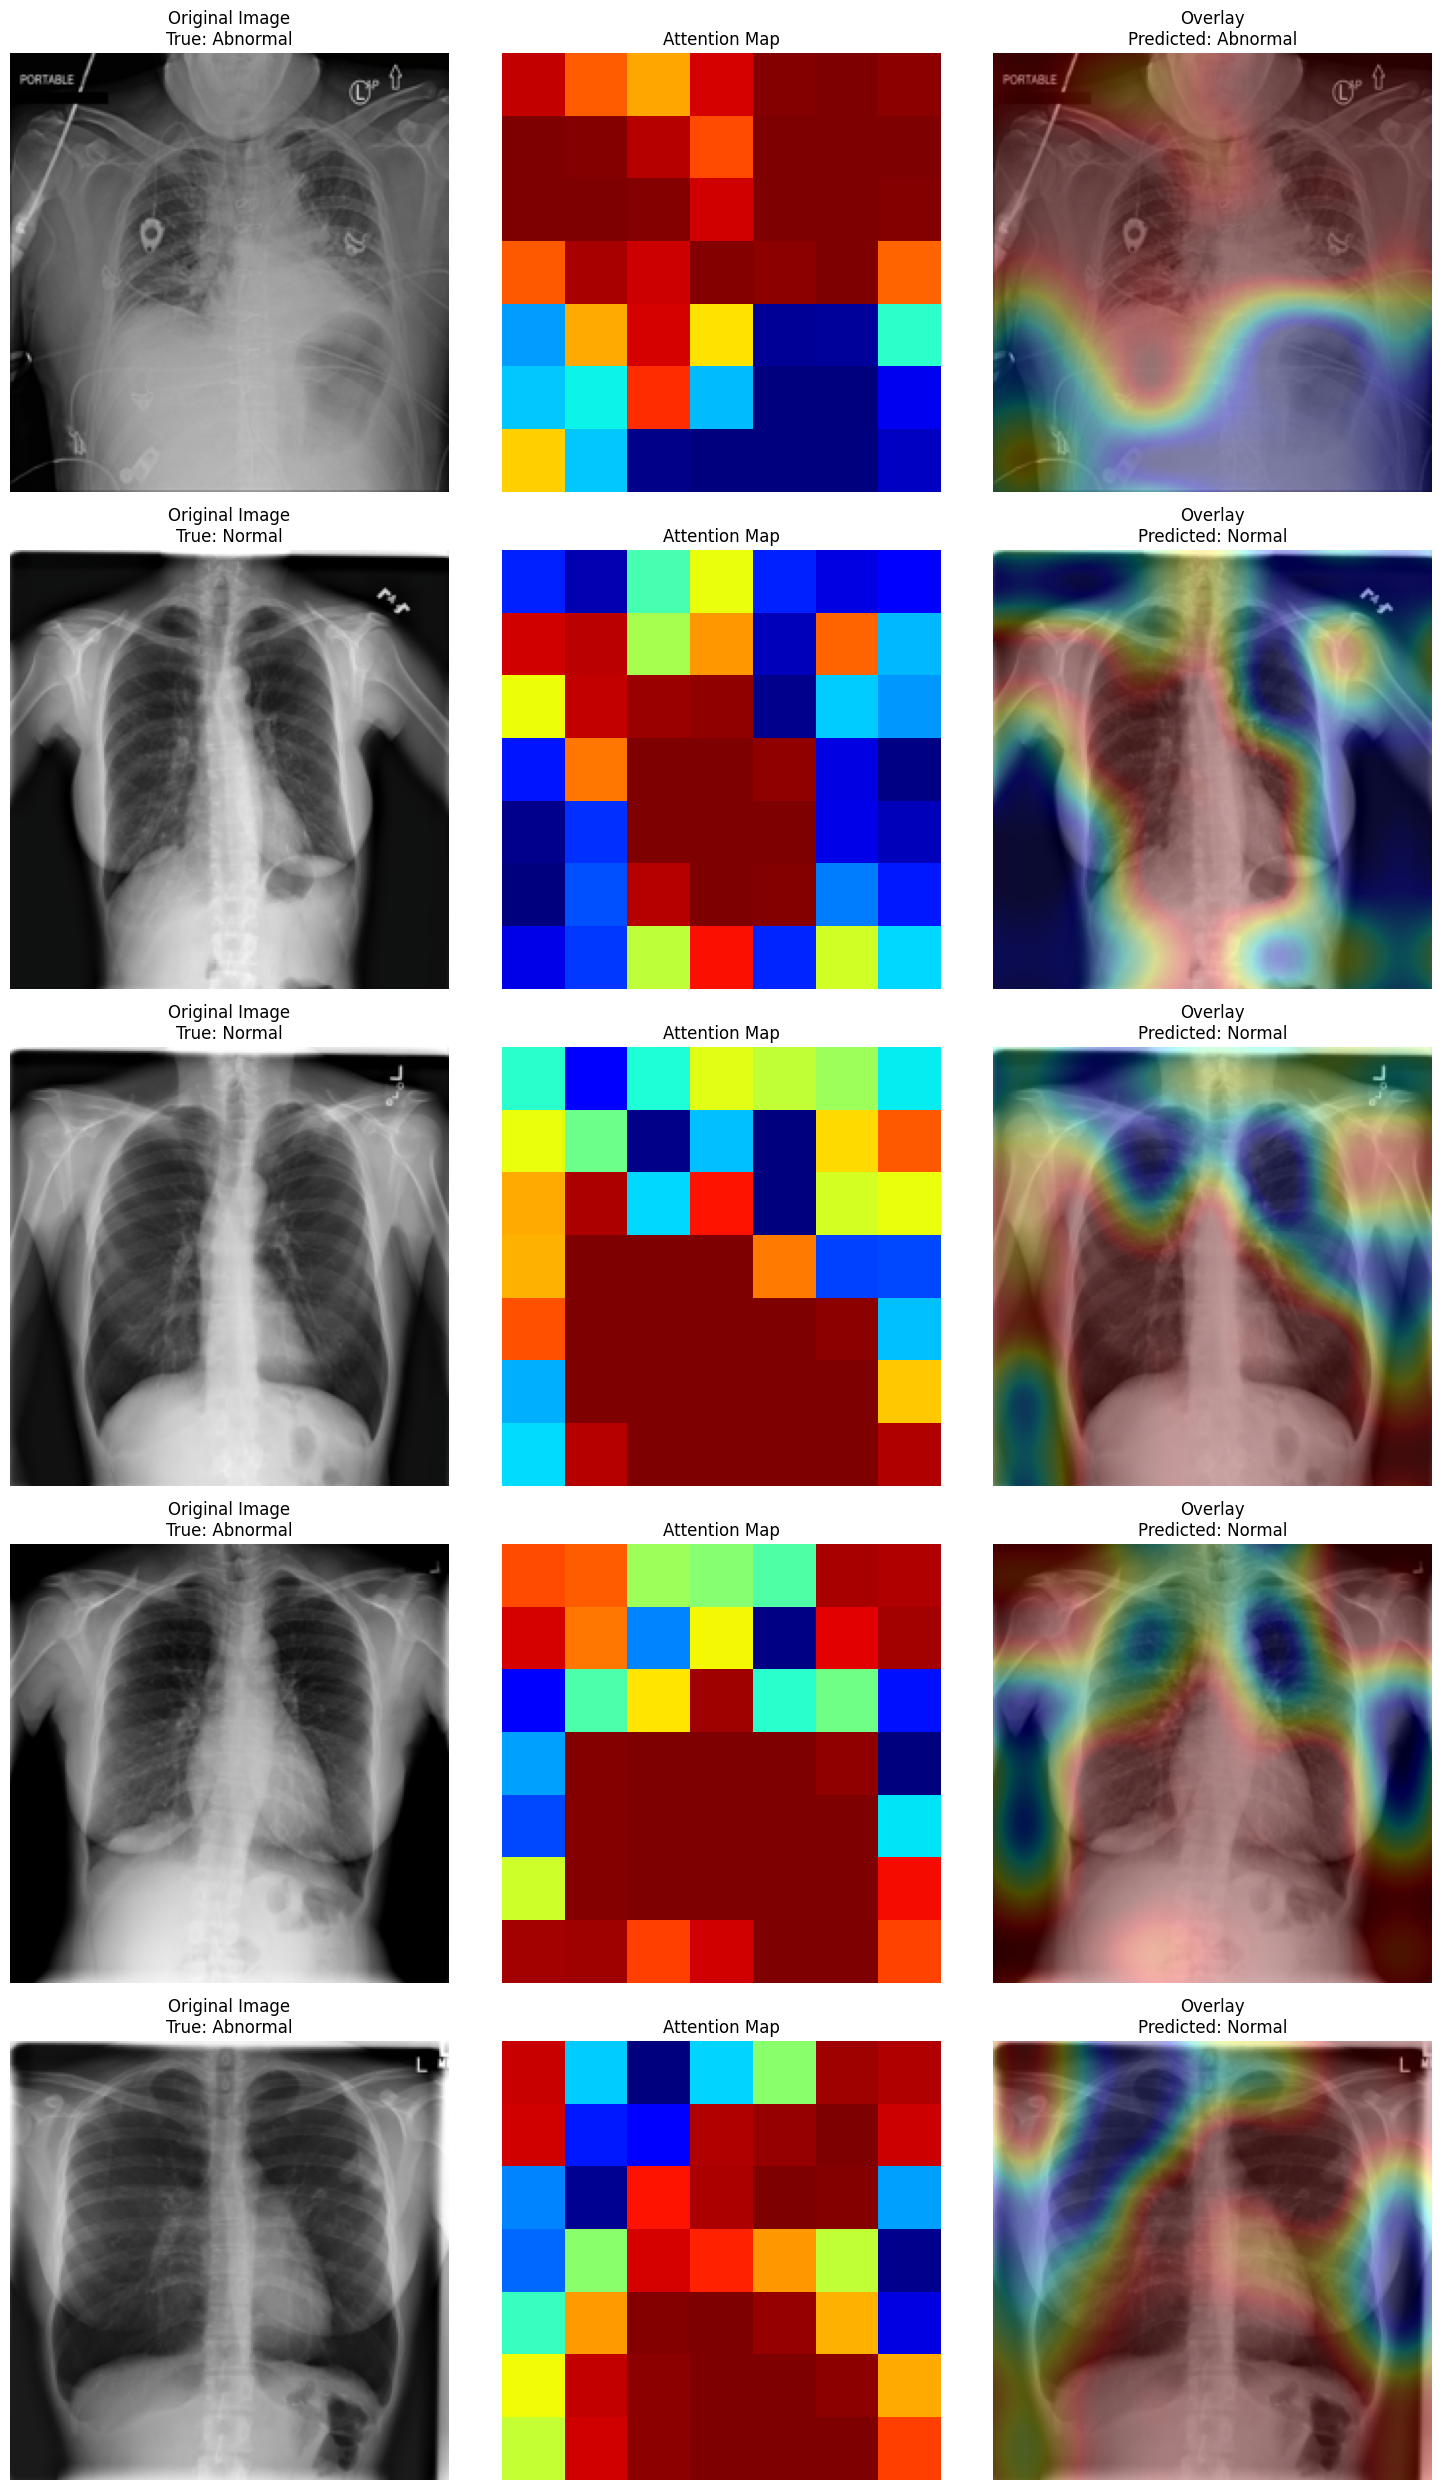

In [33]:
import skimage
def visualize_attention_maps(model, dataloader, num_images=3):
    """
    Visualize attention maps for a few images from the dataset.
    
    Args:
        model: The trained attention model
        dataloader: DataLoader containing the images
        num_images: Number of images to visualize
    """
    # Set model to eval mode
    model.eval()
    
    # Get a batch of images
    images, labels = next(iter(dataloader))
    
    # Limit to specified number of images
    images = images[:num_images]
    labels = labels[:num_images]
    
    # Move to device
    images = images.to(device)
    
    # Get predictions and attention maps
    with torch.no_grad():
        outputs, attention_maps = model(images)
        predictions = (outputs.squeeze() > 0.5).float()
    
    # Convert tensors to numpy for visualization
    images_np = images.cpu().numpy()
    attention_maps_np = attention_maps.cpu().numpy()
    
    # Plot results
    fig, axes = plt.subplots(num_images, 3, figsize=(15, 5*num_images))
    
    if num_images == 1:
        axes = axes.reshape(1, -1)
    
    class_labels = ['Normal', 'Abnormal']
    
    for i in range(num_images):
        # Original image
        img = np.transpose(images_np[i], (1, 2, 0))
        img = (img * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f'Original Image\nTrue: {class_labels[int(labels[i])]}')
        axes[i, 0].axis('off')
        
        # Attention map
        attn_map = attention_maps_np[i, 0]  # Shape: [H, W]
        axes[i, 1].imshow(attn_map, cmap='jet')
        axes[i, 1].set_title('Attention Map')
        axes[i, 1].axis('off')
        
        # Overlay attention on image
        # Resize attention map to match image size
        from skimage.transform import resize
        attn_map_resized = resize(attn_map, (img.shape[0], img.shape[1]), order=3)
        
        # Normalize attention map
        attn_map_resized = (attn_map_resized - attn_map_resized.min()) / (attn_map_resized.max() - attn_map_resized.min())
        
        # Create a colored heatmap
        heatmap = plt.cm.jet(attn_map_resized)[:, :, :3]
        
        # Overlay with transparency
        overlay = 0.7 * img + 0.3 * heatmap
        
        axes[i, 2].imshow(overlay)
        axes[i, 2].set_title(f'Overlay\nPredicted: {class_labels[int(predictions[i])]}')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
# Example usage:
visualize_attention_maps(model, test_loader, num_images=5)

In [34]:
def generate_gradcam(model, input_image, target_class=None):
    """
    Generate Grad-CAM visualization for the model and input image.
    
    Args:
        model: Trained model
        input_image: Input image tensor [1, 3, H, W]
        target_class: Target class for visualization (None for predicted class)
    """
    model.eval()
    
    # Register hooks to get activations and gradients
    activations = []
    gradients = []
    
    def save_activation(module, input, output):
        activations.append(output)
    
    def save_gradient(module, grad_input, grad_output):
        gradients.append(grad_output[0])
    
    # Register forward and backward hooks
    handle1 = model.features.denseblock4.register_forward_hook(save_activation)
    handle2 = model.features.denseblock4.register_full_backward_hook(save_gradient)
    
    # Forward pass
    output, _ = model(input_image)
    pred = output.argmax(dim=1) if output.shape[1] > 1 else (output > 0.5).float()
    
    if target_class is None:
        target_class = pred.item()
    
    # Create one-hot encoding for the target class
    one_hot = torch.zeros_like(output)
    one_hot[0, target_class] = 1
    
    # Backward pass
    model.zero_grad()
    output.backward(gradient=one_hot)
    
    # Get activation and gradient
    activation = activations[0]
    gradient = gradients[0]
    
    # Remove hooks
    handle1.remove()
    handle2.remove()
    
    # Calculate weights and class activation map
    weights = gradient.mean(dim=(2, 3), keepdim=True)
    cam = (weights * activation).sum(dim=1, keepdim=True)
    
    # Apply ReLU and normalize
    cam = F.relu(cam)
    cam = F.interpolate(cam, input_image.shape[2:], mode='bilinear', align_corners=False)
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
    
    return cam

In [35]:
 # For an image from the test set
images, labels = next(iter(test_loader))
image = images[0:1].to(device)  # Get single image and add batch dimension

# Generate Grad-CAM
cam = generate_gradcam(model, image)

# Visualize
plt.imshow(images[0].permute(1,2,0).cpu().numpy())
plt.imshow(cam[0,0].cpu().numpy(), alpha=0.5, cmap='jet')
plt.show()

IndexError: only integers, slices (`:`), ellipsis (`...`), None and long or byte Variables are valid indices (got float)